# Машинное обучение, ФКН ВШЭ
# Exploratory Data Analysis и линейная регрессия

В этом ноутбуке используется библиотека `folium` для визуализации карт.

In [1]:
# !pip install folium

In [2]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

In [3]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import datetime 

%matplotlib inline

## Подготовка данных

Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. 

In [4]:
# train_df = pd.read_csv('./nyc-taxi-trip-duration/train.csv')

`dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. 

В `pickup_datetime` записаны дата и время начала поездки. 

In [5]:
train_df = train_df.drop('dropoff_datetime', axis=1)

In [6]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке.

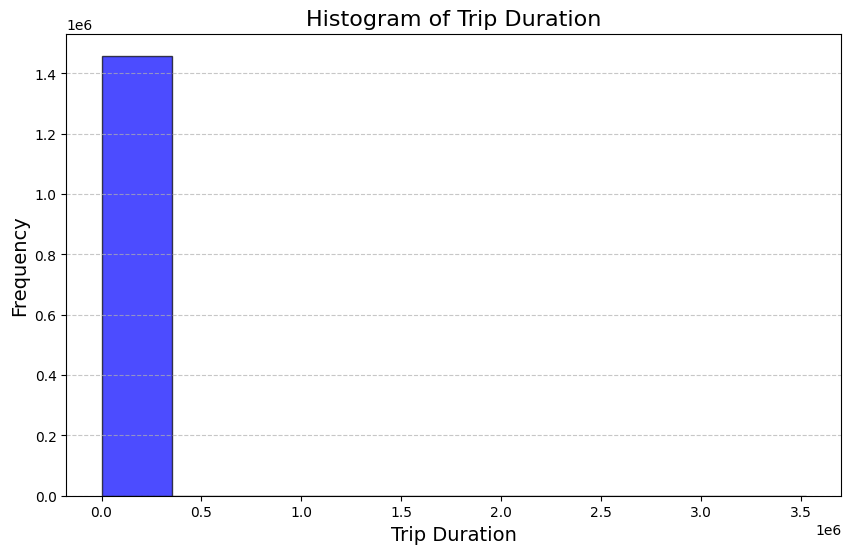

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['trip_duration'], bins=10, color='blue', edgecolor='black', alpha=0.7)

plt.title('Histogram of Trip Duration', fontsize=16)
plt.xlabel('Trip Duration', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [8]:
train_df['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Таргет содержит экстремально большой разброс значений (от 1 до 3 526 282).Поэтому гистограмма строится с одним видимым бином: большая часть значений оказывается сгруппированной в узком диапазоне, в то время как выбросы существенно искажают масштаб.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

RMSLE используется для оценки точности прогнозных моделей, когда важно учитывать относительные ошибки, а не абсолютные значения ошибок. Это особенно актуально в задачах с сильно различающимися масштабами целевой переменной, где ошибки в прогнозах больших значений не должны доминировать над ошибками меньших значений. У нас именно такой случай.

Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Покажем, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:

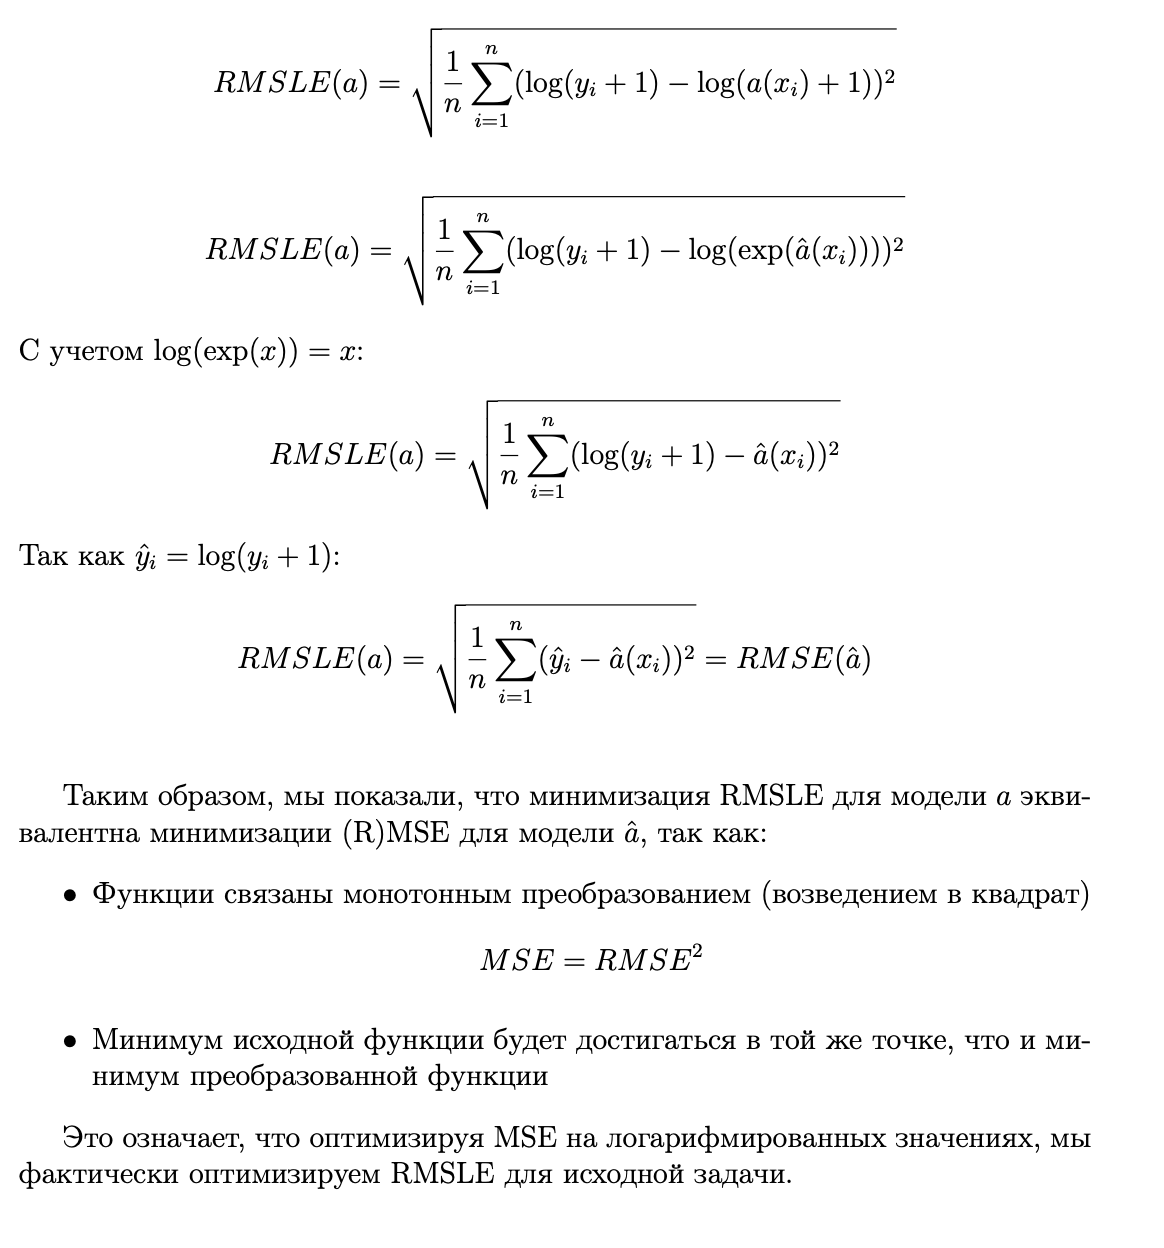

Прологарифмируем таргет

In [9]:
train_df['log_trip_duration'] = np.log1p(train_df['trip_duration'])

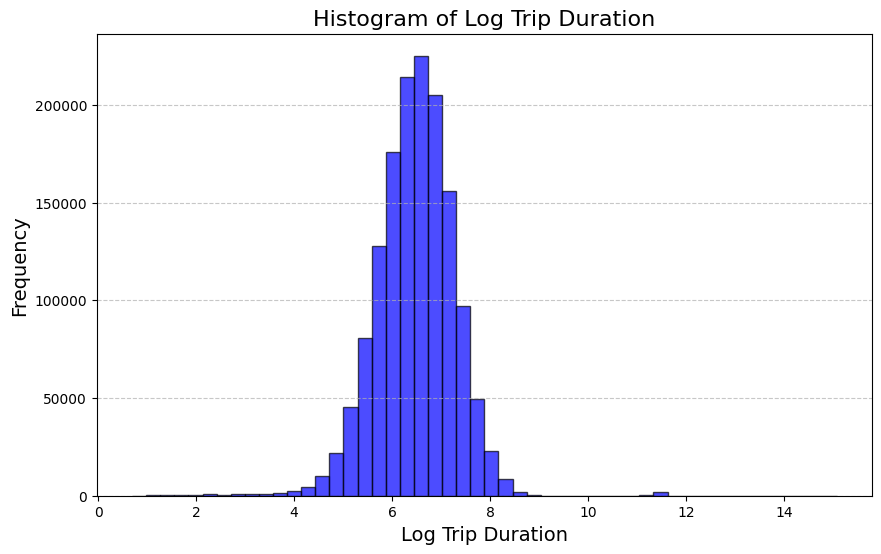

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['log_trip_duration'], bins=50, color='blue', edgecolor='black', alpha=0.7)

plt.title('Histogram of Log Trip Duration', fontsize=16)
plt.xlabel('Log Trip Duration', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [11]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))

rmsle_best_const = rmsle(train_df['log_trip_duration'], train_df['log_trip_duration'].mean())
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


# Изучаем `pickup_datetime`

Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. 

In [12]:
train_df['date'] = train_df['pickup_datetime'].dt.date
train_df['date'] = train_df['date'].astype('datetime64[ns]')

In [13]:
group_by_date = train_df.groupby(by='date').agg({'id': 'count'}).reset_index().rename(columns={'id': 'id_count'})

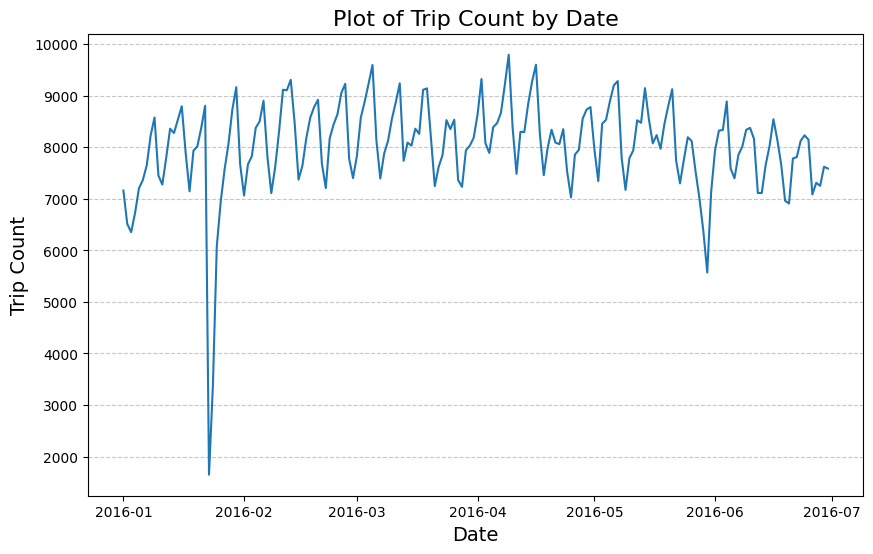

In [14]:
fig_count_by_date, ax = plt.subplots(figsize=(10, 6))
plt.plot(group_by_date['date'], group_by_date['id_count'])

ax.set_title('Plot of Trip Count by Date', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Trip Count', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

Заметно, что на графике есть 2 периода с аномально маленькими количествами поездок. 

In [15]:
group_by_date.loc[group_by_date['id_count'] < 6000]

,date,id_count
22,2016-01-23,1648
23,2016-01-24,3383
150,2016-05-30,5570


1. 23-24 января 2016: снежная буря и запрет автомобильного движения в Нью-Йорке
2. 30 мая: Memorial Day

In [16]:
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df['day_name'] = train_df['pickup_datetime'].dt.day_name()

In [17]:
group_by_hour = train_df.groupby(by='hour').agg({'id': 'count'}).reset_index().rename(columns={'id': 'id_count'})

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

train_df['day_name'] = pd.Categorical(
    train_df['day_name'],
    categories=ordered_days,
    ordered=True
)
group_by_day_name = train_df.groupby(by='day_name', observed=False).agg({'id': 'count'}).reset_index().rename(columns={'id': 'id_count'})

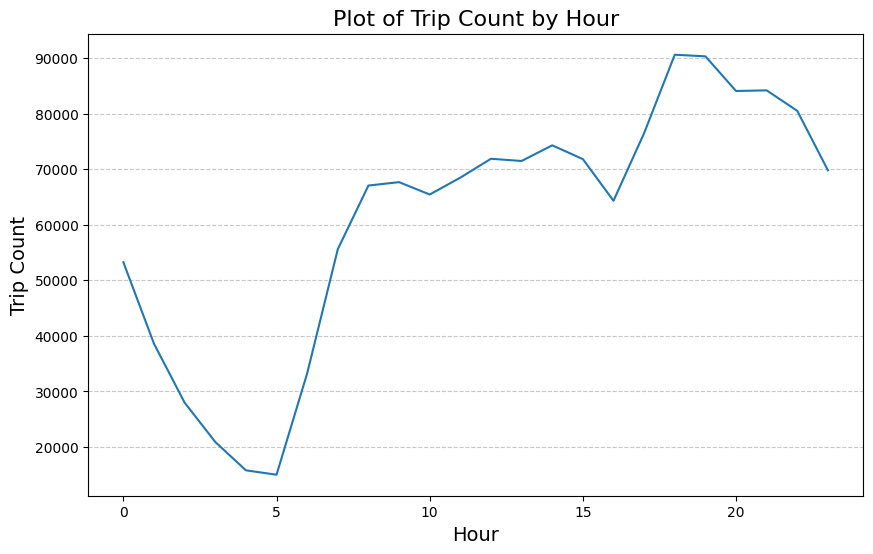

In [18]:
fig_count_by_hour, ax = plt.subplots(figsize=(10, 6))
plt.plot(group_by_hour['hour'], group_by_hour['id_count'])

ax.set_title('Plot of Trip Count by Hour', fontsize=16)
ax.set_xlabel('Hour', fontsize=14)
ax.set_ylabel('Trip Count', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

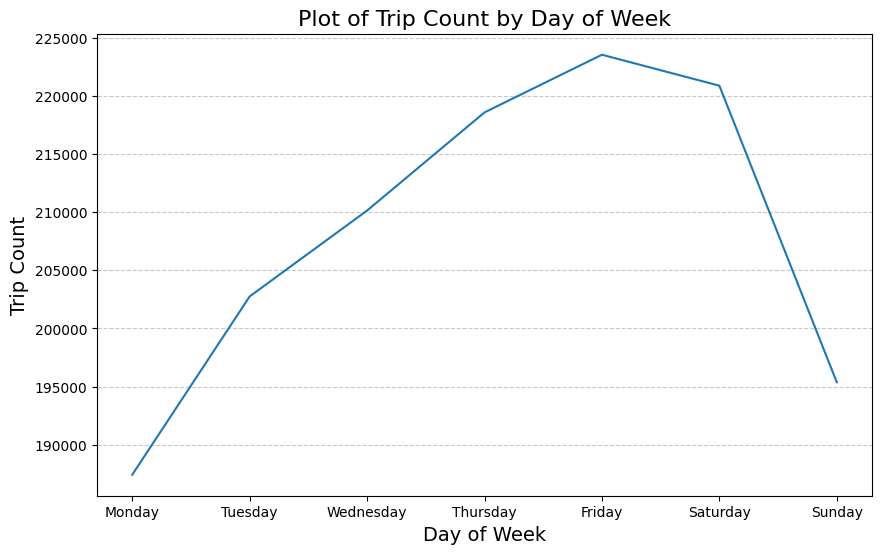

In [19]:
fig_count_by_day_name, ax = plt.subplots(figsize=(10, 6))
ax.plot(group_by_day_name['day_name'], group_by_day_name['id_count'])

ax.set_title('Plot of Trip Count by Day of Week', fontsize=16)
ax.set_xlabel('Day of Week', fontsize=14)
ax.set_ylabel('Trip Count', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

In [20]:
train_df['month'] = train_df['pickup_datetime'].dt.month

In [21]:
group_by_month_hour = train_df.groupby(by=['month', 'hour']).agg({'id': 'count'}).reset_index().rename(columns={'id': 'id_count'})
group_by_day_name_hour = train_df.groupby(by=['day_name', 'hour'], observed=False).agg({'id': 'count'}).reset_index().rename(columns={'id': 'id_count'})

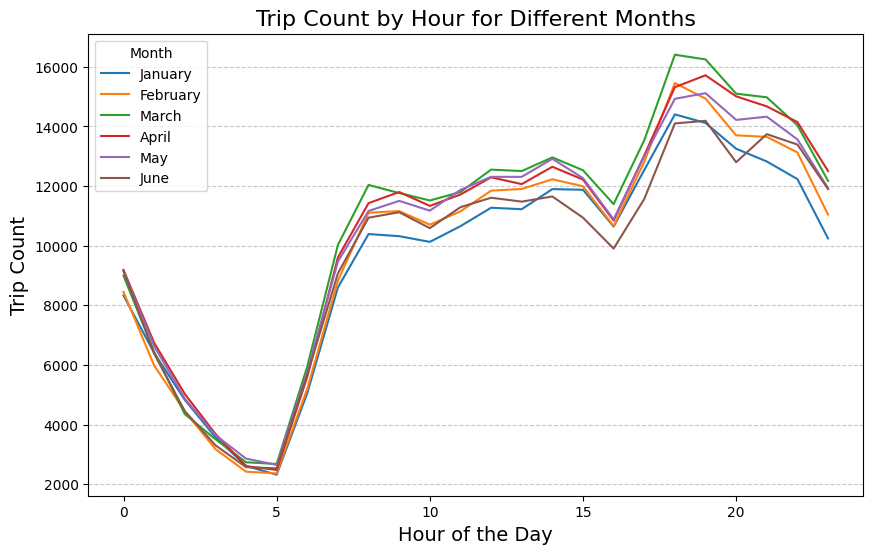

In [22]:
plt.figure(figsize=(10, 6))

months_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June'
}

for month in group_by_month_hour['month'].unique():
    monthly_data = group_by_month_hour[group_by_month_hour['month'] == month]
    plt.plot(
        monthly_data['hour'],
        monthly_data['id_count'],
        label=f'{months_dict[month]}'
    )

plt.title('Trip Count by Hour for Different Months', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Trip Count', fontsize=14)
plt.legend(title="Month", loc="best")  # Легенда
plt.grid(axis='y', linestyle='--', alpha=0.7)

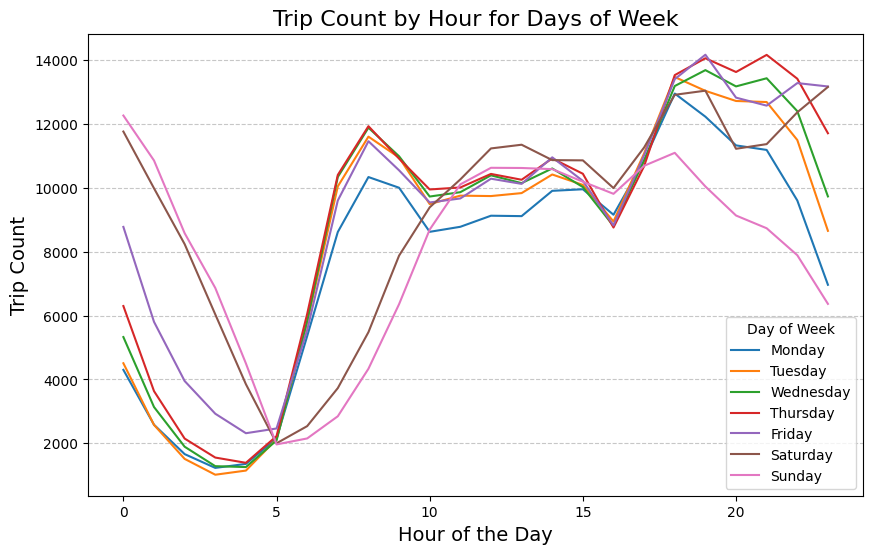

In [23]:
plt.figure(figsize=(10, 6))

months_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June'
}

for day_name in group_by_day_name_hour['day_name'].unique():
    day_name_data = group_by_day_name_hour[group_by_day_name_hour['day_name'] == day_name]
    plt.plot(
        day_name_data['hour'],
        day_name_data['id_count'],
        label=f'{day_name}'
    )

plt.title('Trip Count by Hour for Days of Week', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Trip Count', fontsize=14)
plt.legend(title="Day of Week", loc="best")  # Легенда
plt.grid(axis='y', linestyle='--', alpha=0.7)

Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [24]:
train_df['day_n'] = train_df['pickup_datetime'].dt.strftime('%j').astype(int)

In [25]:
np.random.seed(42)

from sklearn.model_selection import train_test_split
    
X_train, X_test = train_test_split(train_df, test_size=0.3)

In [26]:
target_by_day_name = X_train.groupby(
    by='day_name', observed=False).agg({'log_trip_duration': 'mean'}
                                      ).reset_index().rename(columns={'log_trip_duration': 'mean_log_trip_duration'})

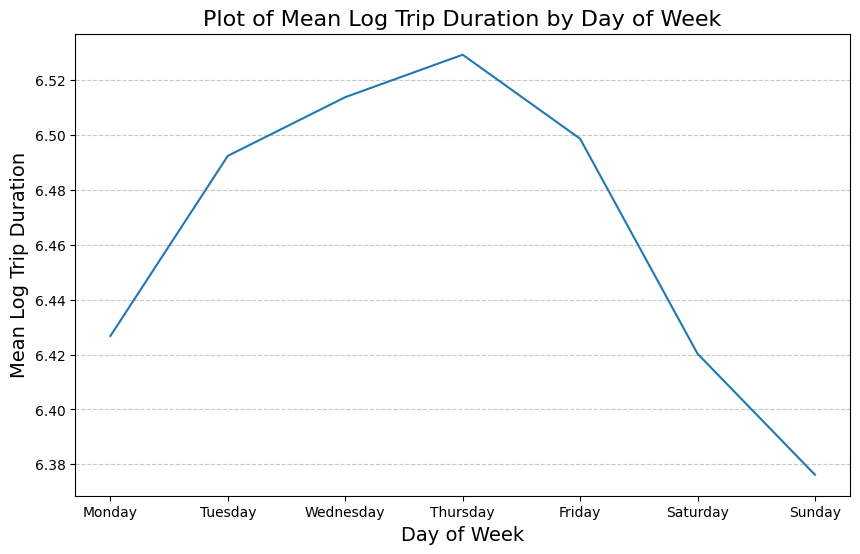

In [27]:
fig_target_by_day_name, ax = plt.subplots(figsize=(10, 6))
ax.plot(target_by_day_name['day_name'], target_by_day_name['mean_log_trip_duration'])

ax.set_title('Plot of Mean Log Trip Duration by Day of Week', fontsize=16)
ax.set_xlabel('Day of Week', fontsize=14)
ax.set_ylabel('Mean Log Trip Duration', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

In [28]:
target_by_hour = X_train.groupby(
    by='hour', observed=False).agg({'log_trip_duration': 'mean'}
                                      ).reset_index().rename(columns={'log_trip_duration': 'mean_log_trip_duration'})

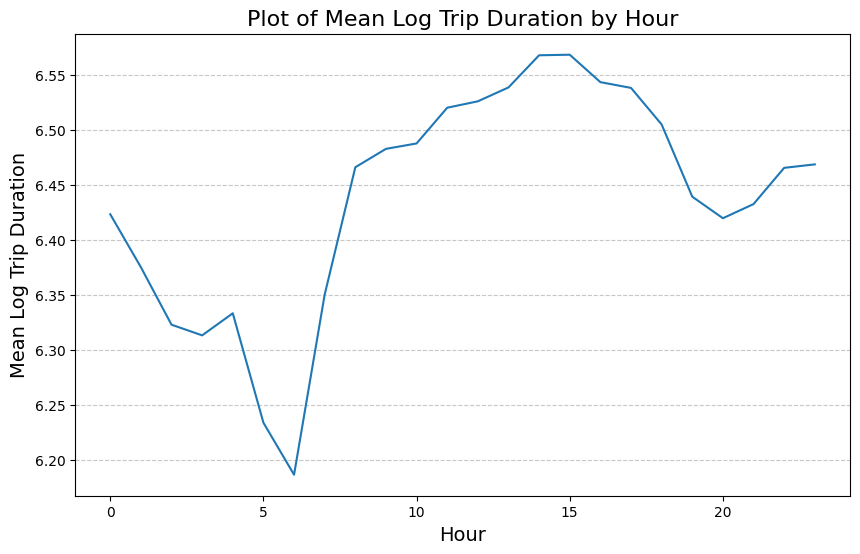

In [29]:
fig_target_by_hour, ax = plt.subplots(figsize=(10, 6))
ax.plot(target_by_hour['hour'], target_by_hour['mean_log_trip_duration'])

ax.set_title('Plot of Mean Log Trip Duration by Hour', fontsize=16)
ax.set_xlabel('Hour', fontsize=14)
ax.set_ylabel('Mean Log Trip Duration', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

In [30]:
target_by_date = X_train.groupby(
    by='date', observed=False).agg({'log_trip_duration': 'mean'}
                                      ).reset_index().rename(columns={'log_trip_duration': 'mean_log_trip_duration'})

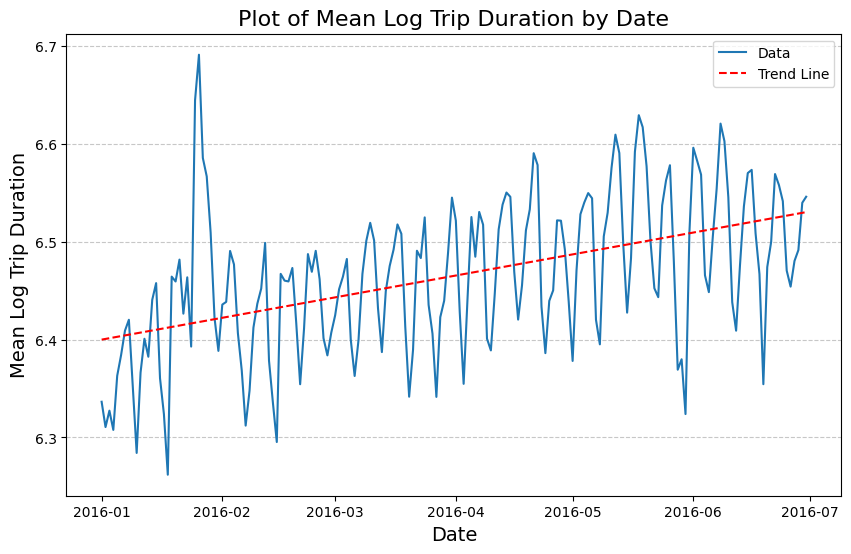

In [31]:
fig_target_by_date, ax = plt.subplots(figsize=(10, 6))

x = target_by_date['date']
y = target_by_date['mean_log_trip_duration']

x_numeric = np.arange(len(x))
coefficients = np.polyfit(x_numeric, y, deg=1)
trend = np.poly1d(coefficients)
ax.plot(x, y, label='Data')
ax.plot(x, trend(x_numeric), label='Trend Line', linestyle='--', color='red')

ax.set_title('Plot of Mean Log Trip Duration by Date', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Mean Log Trip Duration', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

plt.show()

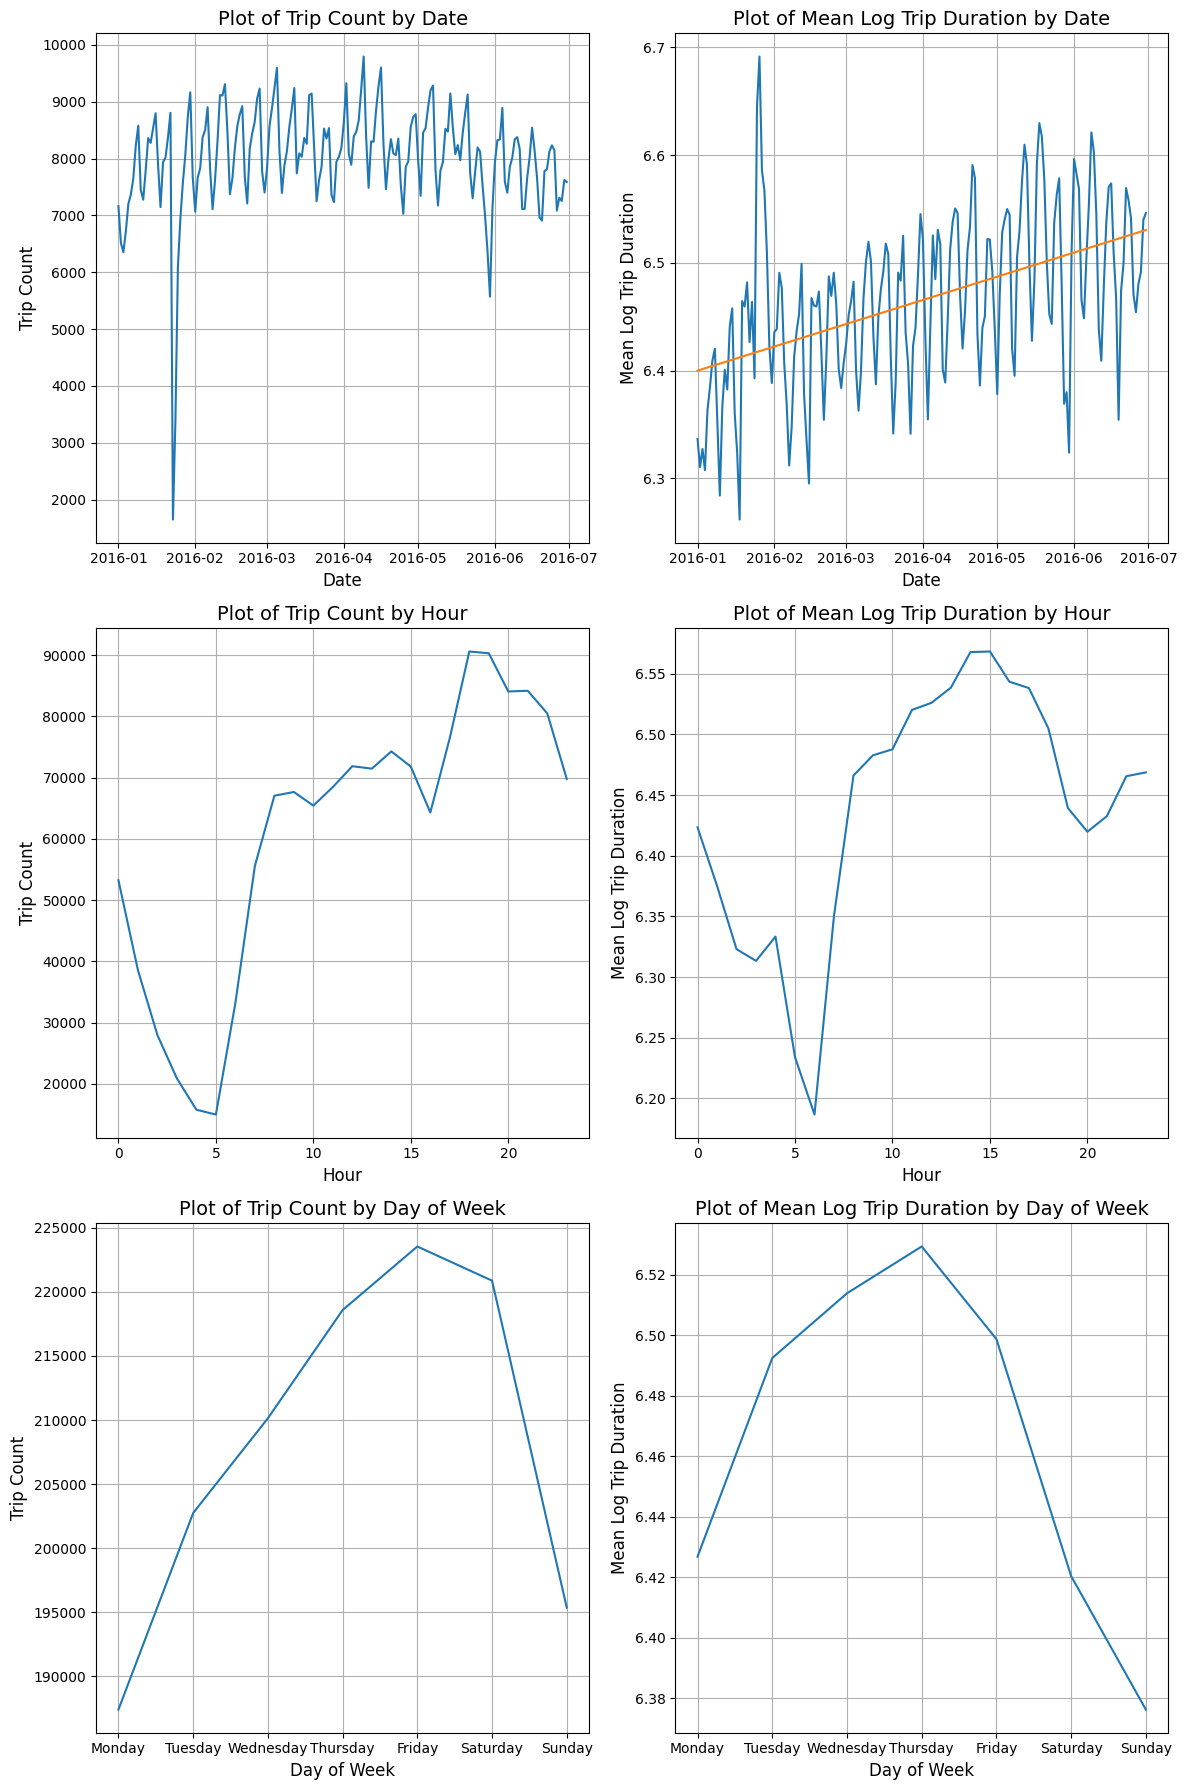

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.ravel()

figures = [
    fig_count_by_date, fig_target_by_date, 
    fig_count_by_hour, fig_target_by_hour, 
    fig_count_by_day_name, fig_target_by_day_name
]

for i, (figure, ax) in enumerate(zip(figures, axes)):
    for line in figure.axes[0].lines:  
        ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
    ax.set_title(figure.axes[0].get_title(), fontsize=14)
    ax.set_xlabel(figure.axes[0].get_xlabel(), fontsize=12)
    ax.set_ylabel(figure.axes[0].get_ylabel(), fontsize=12)
    ax.grid(True)

plt.tight_layout()

- Графики количество поездок - день недели и таргет - день недели похожи, но не во всем. Например, мы видим, что количество поездок максимально в пятницу, но их средняя длительность при этом максимальна в четверг. В субботу же поездок лишь немногим меньше, чем в пятницу, однако они в среднем короче, чем все поездки в будние дни.
- Графики количество поездок - час в сутках и таргет - час в сутках: обладают общим паттерном, однако, во время рабочего дня (9 - 16ч) примерно постоянное количество поездок, а дальше наблюдается рост. При этом вечерние поездки скорее короче, чем дневные.

**Аномальные периоды**

In [33]:
blizzard_dates = [
    datetime.datetime(2016, 1, 23), 
    datetime.datetime(2016, 1, 24), 
    datetime.datetime(2016, 1, 25), 
    datetime.datetime(2016, 1, 26), 
    datetime.datetime(2016, 1, 27),
    datetime.datetime(2016, 1, 28)
]
blizzard_df = train_df.loc[train_df['date'].isin(blizzard_dates)]

In [34]:
blizzard_df.groupby(by=['date', 'day_name'], observed=True).agg({'id': 'count'}).reset_index().rename(columns={'id': 'count_ids'})

,date,day_name,count_ids
0,2016-01-23,Saturday,1648
1,2016-01-24,Sunday,3383
2,2016-01-25,Monday,6084
3,2016-01-26,Tuesday,6941
4,2016-01-27,Wednesday,7571
5,2016-01-28,Thursday,8066


In [35]:
blizzard_df.groupby(by=['date', 'day_name'], observed=True).agg({'log_trip_duration': 'mean'}).reset_index().rename(columns={'log_trip_duration': 'mean_log_trip_duration'})

,date,day_name,mean_log_trip_duration
0,2016-01-23,Saturday,6.456000
1,2016-01-24,Sunday,6.395089
2,2016-01-25,Monday,6.655111
3,2016-01-26,Tuesday,6.688287
4,2016-01-27,Wednesday,6.595148
5,2016-01-28,Thursday,6.558443


In [36]:
anomaly_mask1 = train_df['date'].isin(blizzard_dates) 

In [37]:
memory_dates = [
    datetime.datetime(2016, 5, 28), 
    datetime.datetime(2016, 5, 29), 
    datetime.datetime(2016, 5, 30), 
    datetime.datetime(2016, 5, 31), 
    datetime.datetime(2016, 6, 1), 
]

memory_df = train_df.loc[train_df['date'].isin(memory_dates)]

In [38]:
memory_df.groupby(by=['date', 'day_name'], observed=True).agg({'id': 'count'}).reset_index().rename(columns={'id': 'count_ids'})

,date,day_name,count_ids
0,2016-05-28,Saturday,7004
1,2016-05-29,Sunday,6372
2,2016-05-30,Monday,5570
3,2016-05-31,Tuesday,7131
4,2016-06-01,Wednesday,7943


In [39]:
memory_df.groupby(by=['date', 'day_name'], observed=True).agg({'log_trip_duration': 'mean'}).reset_index().rename(columns={'log_trip_duration': 'mean_log_trip_duration'})

,date,day_name,mean_log_trip_duration
0,2016-05-28,Saturday,6.370151
1,2016-05-29,Sunday,6.371315
2,2016-05-30,Monday,6.321035
3,2016-05-31,Tuesday,6.509759
4,2016-06-01,Wednesday,6.592929


In [40]:
anomaly_mask2 = train_df['date'].isin([datetime.datetime(2016, 5, 30)]) 

Добавим следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [41]:
train_df['anomaly1'] = 0
train_df['anomaly2'] = 0

train_df.loc[anomaly_mask1, 'anomaly1'] = 1
train_df.loc[anomaly_mask2, 'anomaly2'] = 1

In [42]:
df = train_df.drop([
    'id', 'pickup_datetime', 'date', 'vendor_id', 'passenger_count', 
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag', 'log_trip_duration', 'trip_duration'
                   ], axis=1)

y = train_df['log_trip_duration']

Определим, какие признаки, из созданных нами, стоит рассматривать как категориальные, а какие - как численные.

1. День недели -- категориальный: имеет четкий порядковый смысл (1-7), но нет линейной зависимости между номером дня и длительностью поездки, каждый день может иметь свои уникальные паттерны трафика (например, выходные vs будни)
2. Месяц -- категориальный: нет прямой линейной связи между номером месяца и длительностью поездки, каждый месяц может иметь свою специфику (погода, праздники, туристический сезон)
3. Час -- категориальный: связь между часом и длительностью поездки нелинейная, разные часы имеют четкие паттерны трафика (час пик, ночное время)
4. Номер дня в году -- численный: заметен тренд (график таргет - дата), а также если преобразовывать в категории то получилось бы слишком много признаков, что может привести к переобучению

Обучим `Ridge`-регрессию на новых признаках с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируем с помощью `StandardScaler`.

In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)

In [48]:
numeric_features = ['day_n']
categorical_features = ['hour', 'day_name', 'month', 'anomaly1', 'anomaly2']

preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
)

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge()) 
    ])

In [49]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [50]:
rmsle(y_test, y_pred)

0.7913182620726459

## Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки.

Напишем функцию, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и отрисуем на карте.

In [51]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [52]:
sub_train_df = train_df.sample(1000)

your_lat_values = sub_train_df['pickup_latitude'].values
your_lon_values = sub_train_df['pickup_longitude'].values

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

Абсолютное большинство точек старта поездок находятся на Манхэттэне. Так же хорошо заметен кластеры двух аэропортов и железнодорожного вокзала на Манхэттене.

Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. 

In [53]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 
    
    return c * r

In [54]:
train_df['haversine'] = train_df.apply(lambda row:  
                                       haversine(row['pickup_longitude'], row['pickup_latitude'], 
                                                 row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$.

In [55]:
train_df['log_haversine'] = np.log1p(train_df['haversine'])

In [56]:
correlation = train_df['log_trip_duration'].corr(train_df['haversine'])
print("Correlation between 'log_trip_duration' and 'haversine':", correlation)

correlation_log = train_df['log_trip_duration'].corr(train_df['log_haversine'])
print("Correlation between 'log_trip_duration' and 'log_haversine':", correlation_log)

Correlation between 'log_trip_duration' and 'haversine': 0.5735948311180146
Correlation between 'log_trip_duration' and 'log_haversine': 0.7498822373942491


Давайте изучим среднюю скорость движения такси.

In [57]:
train_df['average_speed'] = train_df['haversine'] / train_df['trip_duration']

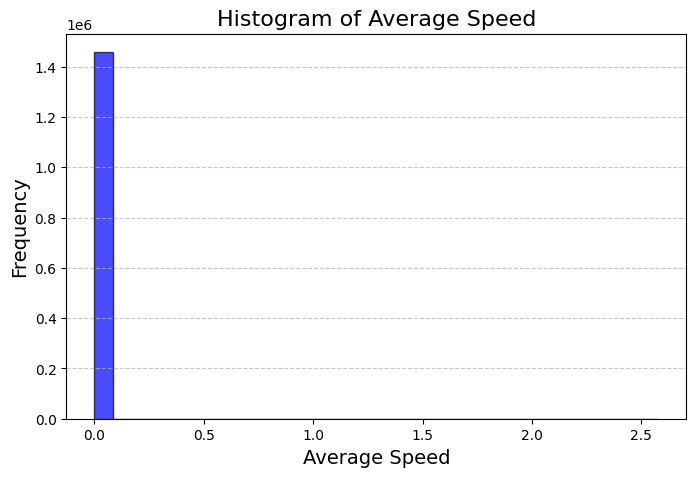

In [58]:
plt.figure(figsize=(8, 5))
plt.hist(train_df['average_speed'], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.title('Histogram of Average Speed', fontsize=16)
plt.xlabel('Average Speed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [59]:
train_df['average_speed'].describe()

count    1.458644e+06
mean     4.006447e-03
std      4.160423e-03
min      0.000000e+00
25%      2.533687e-03
50%      3.553327e-03
75%      4.956920e-03
max      2.576344e+00
Name: average_speed, dtype: float64

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [60]:
tmp_df = train_df[train_df['average_speed'] < train_df['average_speed'].quantile(0.95)]

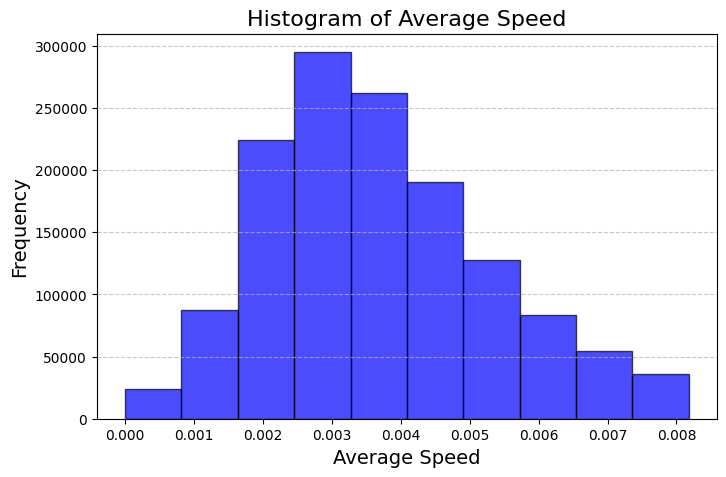

In [61]:
plt.figure(figsize=(8, 5))
plt.hist(tmp_df['average_speed'], bins=10, color='blue', edgecolor='black', alpha=0.7)

plt.title('Histogram of Average Speed', fontsize=16)
plt.xlabel('Average Speed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [62]:
median_speeds = train_df.groupby(
    by=['day_name', 'hour'], observed=False).agg({'average_speed': 'median'}).reset_index().rename(
    columns={'average_speed': 'median_average_speed'}
)

heatmap_data = median_speeds.pivot(index='day_name', columns='hour', values='median_average_speed')

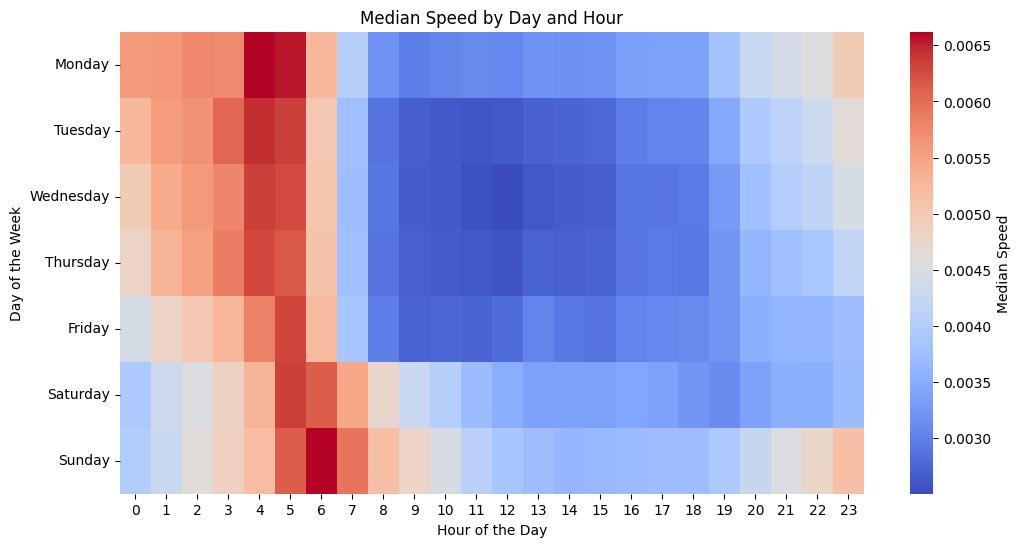

In [63]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Median Speed'})
plt.title("Median Speed by Day and Hour")
plt.ylabel("Day of the Week")
plt.xlabel("Hour of the Day")
plt.show()

Значение скорости нельзя использовать для обучения модели, т.к. оно полученои из расстояния и времени поездки (таргета). На тесте у нас не будет возможности вычислять такой признак (т.к. он зависит от таргета)

Создадим признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [65]:
low_thresh = median_speeds['median_average_speed'].quantile(0.25)
high_thresh = median_speeds['median_average_speed'].quantile(0.75)

low_thresh, high_thresh

(0.0030441654114126606, 0.004970497936218928)

In [66]:
median_speeds = median_speeds.copy()
median_speeds['is_peak_hour'] = (median_speeds['median_average_speed'] < low_thresh).astype(int)
median_speeds['is_free_road'] = (median_speeds['median_average_speed'] > high_thresh).astype(int)

In [67]:
train_df = train_df.merge(median_speeds, on=['day_name', 'hour'])

Для каждого из замеченных кластеров точек старта/окончания поездки добавим в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте


In [70]:
# Добавим аэропорты, координаты из google-карт

locations = {
    'jfk_airport':         (-73.7781, 40.6413),
    'laguardia_airport':   (-73.8740, 40.7769)
}

for name, (lon2, lat2) in locations.items():
    train_df[f'start_near_{name}'] = train_df.apply(
        lambda row: haversine(
            row['pickup_longitude'], row['pickup_latitude'],
            lon2, lat2
        ) < 1,  # расстояние меньше километра 
        axis=1
    ).astype(int)


for name, (lon2, lat2) in locations.items():
    train_df[f'end_near_{name}'] = train_df.apply(
        lambda row: haversine(
            row['dropoff_longitude'], row['dropoff_latitude'],
            lon2, lat2
        ) < 1,  # расстояние меньше 300 метров
        axis=1
    ).astype(int)

Посмотрим на boxplot распределения логарифма времени поездки для каждого из значений новых признаков

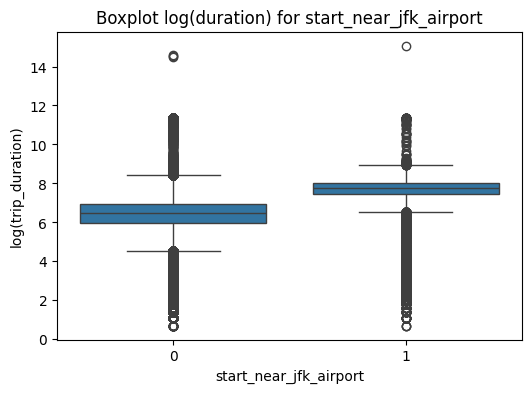

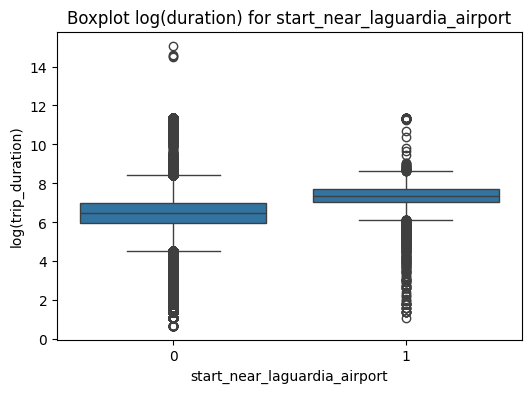

In [71]:
place_flags_start = [col for col in train_df.columns if col.startswith('start_near_')]
for col in place_flags_start:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=col, y='log_trip_duration', data=train_df)
    plt.title(f'Boxplot log(duration) for {col}')
    plt.xlabel(col)
    plt.ylabel('log(trip_duration)')
    plt.show()

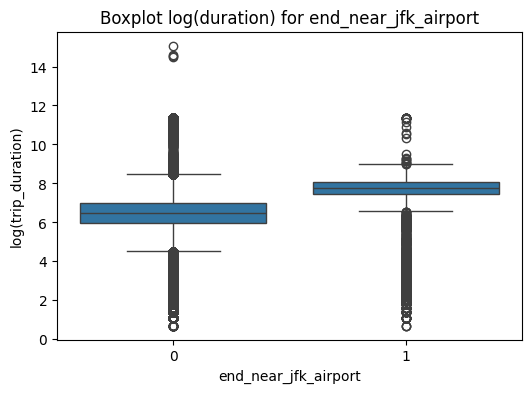

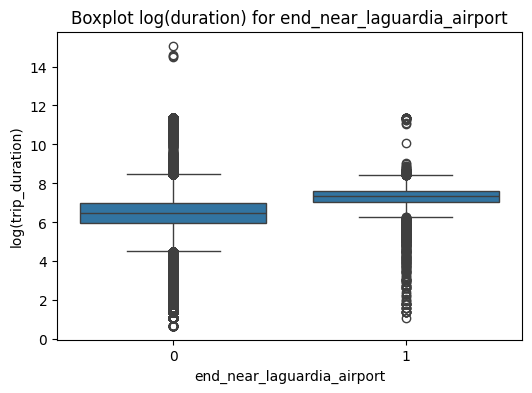

In [72]:
place_flags_end = [col for col in train_df.columns if col.startswith('end_near_')]
for col in place_flags_end:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=col, y='log_trip_duration', data=train_df)
    plt.title(f'Boxplot log(duration) for {col}')
    plt.xlabel(col)
    plt.ylabel('log(trip_duration)')
    plt.show()

Признаки для аэропортов получились хорошими (медианы и квартили смещены для значения признака 1, относительно значения признака 0).

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

manhattan = (-74.03, -73.91, 40.70, 40.81)

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows=5, n_cols=3, bounding_box=None):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.bounding_box = bounding_box

    def fit(self, X=None, y=None):
        if self.bounding_box is None:
            self.min_lon = X['pickup_longitude'].min()
            self.max_lon = X['pickup_longitude'].max()
            self.min_lat = X['pickup_latitude'].min()
            self.max_lat = X['pickup_latitude'].max()

        else:
            self.min_lon, self.max_lon, self.min_lat, self.max_lat = self.bounding_box

        self.lon_step = (self.max_lon - self.min_lon) / self.n_cols
        self.lat_step = (self.max_lat - self.min_lat) / self.n_rows

        return self

    def _get_cell(self, lon, lat):
        col = ((lon - self.min_lon) / self.lon_step).astype(int)
        row = ((lat - self.min_lat) / self.lat_step).astype(int)

        mask = (col >= 0) & (col < self.n_cols) & (row >= 0) & (row < self.n_rows)
        cell = np.where(mask, row * self.n_cols + col, -1)

        return cell

    def transform(self, X, y=None):
        X = X.copy()

        X['pickup_cell'] = self._get_cell(X['pickup_longitude'], X['pickup_latitude'])
        X['dropoff_cell'] = self._get_cell(X['dropoff_longitude'], X['dropoff_latitude'])

        return X

    def draw_grid_on_map(self) -> folium.Map:
        center_lat = (self.min_lat + self.max_lat) / 2
        center_lon = (self.min_lon + self.max_lon) / 2
        m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

        for i in range(self.n_rows):
            for j in range(self.n_cols):
                lat1 = self.min_lat + i * self.lat_step
                lat2 = self.min_lat + (i + 1) * self.lat_step
                lon1 = self.min_lon + j * self.lon_step
                lon2 = self.min_lon + (j + 1) * self.lon_step

                folium.Rectangle(
                    bounds=[(lat1, lon1), (lat2, lon2)],
                    color="red",
                    weight=2,
                    fill=False
                ).add_to(m)

        return m

In [74]:
mgt = MapGridTransformer(n_rows=6, n_cols=4, bounding_box=manhattan)
mgt.fit(X=train_df)

MapGridTransformer(bounding_box=(-74.03, -73.91, 40.7, 40.81), n_cols=4,
                   n_rows=6)

In [75]:
mgt.draw_grid_on_map()

In [76]:
train_df = mgt.transform(X=train_df)

Обучим `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту.

In [77]:
df = train_df[['hour', 'day_name', 'month', 'day_n',
       'anomaly1', 'anomaly2', 'log_haversine', 'is_peak_hour', 'is_free_road',
       'start_near_jfk_airport', 'start_near_laguardia_airport',
       'end_near_jfk_airport', 'end_near_laguardia_airport',
       'pickup_cell', 'dropoff_cell']]

y = train_df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=123)

numeric_features = ['day_n', 'log_haversine']
categorical_features = ['hour', 'day_name', 'month', 'anomaly1', 'anomaly2', 'is_peak_hour', 'is_free_road',
       'start_near_jfk_airport', 'start_near_laguardia_airport',
       'end_near_jfk_airport', 'end_near_laguardia_airport', 'pickup_cell',
       'dropoff_cell']

preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
)

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge()) 
    ])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [78]:
rmsle(y_test, y_pred)

0.47228215808129653

In [79]:
regressor = pipeline.named_steps['regressor']
weights = regressor.coef_

In [80]:
feature_names = np.concatenate([
    preprocessor.transformers_[0][2],
    preprocessor.transformers_[1][1].get_feature_names_out(preprocessor.transformers_[1][2])
])

idx = np.argmax(weights)
print("Признак с наибольшим весом:", feature_names[idx])

Признак с наибольшим весом: log_haversine


Это было ожидаемо

## Изучаем оставшиеся признаки 

У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

In [81]:
train_df['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

In [82]:
train_df['passenger_count'].value_counts()

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

In [83]:
train_df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

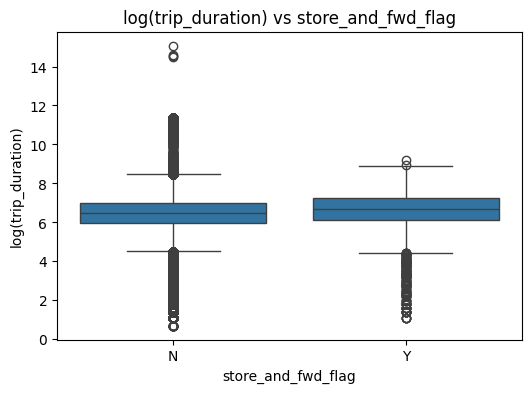

In [84]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=train_df)
plt.title('log(trip_duration) vs store_and_fwd_flag')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('log(trip_duration)')
plt.show()

Признак может быть полезным, т.к. при флаге Y мы не наблюдаем длинных поездок вообще, хотя медиана и квартили смещены незначительно

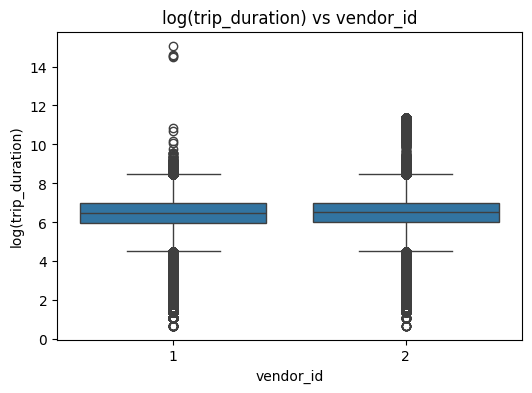

In [85]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='vendor_id', y='log_trip_duration', data=train_df)
plt.title('log(trip_duration) vs vendor_id')
plt.xlabel('vendor_id')
plt.ylabel('log(trip_duration)')
plt.show()

In [86]:
tmp_df = train_df[['passenger_count', 'log_trip_duration']].copy()

def make_passenger_count_flag(number):
    if number > 4:
        return '4+'
    else:
        return number


tmp_df['passenger_count_flag'] = tmp_df.apply(
    lambda row: make_passenger_count_flag(row['passenger_count']), axis=1)

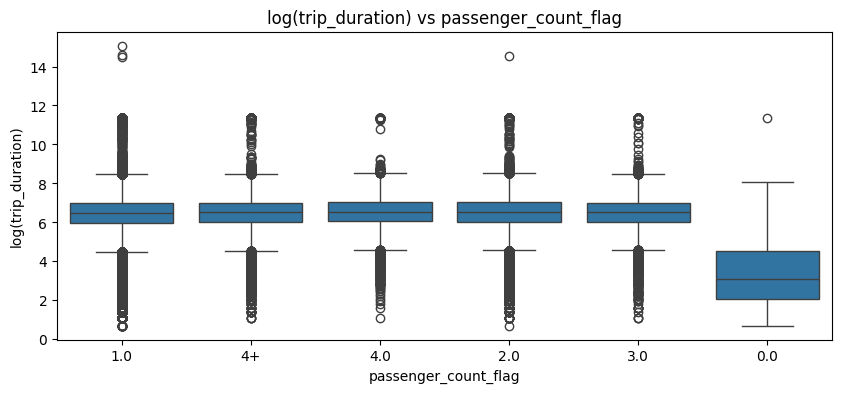

In [87]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='passenger_count_flag', y='log_trip_duration', data=tmp_df)
plt.title('log(trip_duration) vs passenger_count_flag')
plt.xlabel('passenger_count_flag')
plt.ylabel('log(trip_duration)')
plt.show()

Здесь четко выделяется группа объектов с passenger_count = 0 (что это вообще такое?)

Переведем признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [88]:
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})
train_df['vendor_id'] = train_df['vendor_id'].map({1: 0, 2: 1})

- vendor_id -- не выглядит полезным
- store_and_fwd_flag -- распределения отличаются, выглядит полезным
- passenger_count -- можно преобразовать в бинарный (0 vs other)

In [89]:
passenger_count_dict = {
    1.0: 0,
    2.0: 0,
    3.0: 0,
    4.0: 0,
    '4+': 0,
    0.0: 1
}

train_df['passenger_count_flag'] = train_df.apply(
    lambda row: make_passenger_count_flag(row['passenger_count']), axis=1)


train_df['passenger_count_flag'] = train_df['passenger_count'].map(passenger_count_dict)

Проверим свои предположения, обучив модель в том числе и на этих трех признаках. 

In [90]:
df = train_df[['hour', 'day_name', 'month', 'day_n',
       'anomaly1', 'anomaly2', 'log_haversine', 'is_peak_hour', 'is_free_road',
       'start_near_jfk_airport', 'start_near_laguardia_airport',
       'end_near_jfk_airport', 'end_near_laguardia_airport',
       'pickup_cell', 'dropoff_cell', 'passenger_count_flag', 'store_and_fwd_flag']]

y = train_df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=123)

numeric_features = ['day_n', 'log_haversine']
categorical_features = ['hour', 'day_name', 'month', 'anomaly1', 'anomaly2', 'is_peak_hour', 'is_free_road',
       'start_near_jfk_airport', 'start_near_laguardia_airport',
       'end_near_jfk_airport', 'end_near_laguardia_airport','pickup_cell',
       'dropoff_cell', 'passenger_count_flag', 'store_and_fwd_flag']

preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
)

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge()) 
    ])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [91]:
rmsle(y_test, y_pred)

0.4721741010311695

Стало чуть лучше

### Сравним Lasso и Ridge

Попробуем обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [105]:
from sklearn.linear_model import Lasso

ridge = Ridge()
lasso = Lasso()

In [106]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
        ]
)

pipeline_ridge = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor',ridge) 
    ])

pipeline_lasso = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', lasso) 
    ])

In [107]:
pipeline_ridge.fit(X_train, y_train)
pipeline_lasso.fit(X_train, y_train)

y_pred_ridge = pipeline_ridge.predict(X_test)
y_pred_lasso = pipeline_lasso.predict(X_test)

In [109]:
print(f'ridge rmsle = {rmsle(y_test, y_pred_ridge)}')
print(f'lasso rmsle = {rmsle(y_test, y_pred_lasso)}')

ridge rmsle = 0.4721741010311695
lasso rmsle = 0.792532757217006


Lasso показал себя сильно хуже, хотя скорее-всего дело в неподобранном коэффициенте для регуляризации

In [110]:
from sklearn.model_selection import GridSearchCV


alphas = np.logspace(-4, 0, 20)

params_ridge = {'regressor__alpha': alphas}

ridge_grid = GridSearchCV(
    pipeline_ridge,
    params_ridge,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

ridge_grid.fit(X_train, y_train)

/Users/janezaletskaya/envs/mlenv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/janezaletskaya/envs/mlenv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/janezaletskaya/envs/mlenv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/janezaletskaya/envs/mlenv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/janezaletskay

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['day_n',
                                                                          'log_haversine']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['hour',
                                                                          'day_name',
                                                                          'month',
                                                                          'anomaly1',
                                                                          'anomaly2',
                                                                          'is_peak_hour',
                                                                          'is_free_road',
                                                                          'start_near_jfk_airport',
                                                                          'start_near_laguardia_ai...
             param_grid={'regressor__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             scoring='neg_root_mean_squared_error')

In [111]:
y_test_pred_ridge = ridge_grid.best_estimator_.predict(X_test)
rmsle_ridge = rmsle(y_test, y_test_pred_ridge)

print("Лучший Ridge alpha:", ridge_grid.best_params_['regressor__alpha'])
print("Ridge RMSLE на тесте:", rmsle_ridge)

Лучший Ridge alpha: 1.0
Ridge RMSLE на тесте: 0.4721741010311695


In [112]:
coefs = []
rmsle_scores = []

alphas = np.logspace(-4, 0, 20)

for alpha in alphas:
    pipeline_lasso = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=alpha, max_iter=10000))
    ])
    
    pipeline_lasso.fit(X_train, y_train)
    model = pipeline_lasso.named_steps['regressor']
    
    coefs.append(np.sum(model.coef_ == 0))
    
    y_pred = pipeline_lasso.predict(X_test)
    rmsle_score = rmsle(y_test, y_pred)
    rmsle_scores.append(rmsle_score)

In [113]:
print("Лучший Lasso alpha:", alphas[np.argmin(rmsle_scores)])
print("Lasso RMSLE на тесте:", min(rmsle_scores))

Лучший Lasso alpha: 0.0001
Lasso RMSLE на тесте: 0.4725971134591706


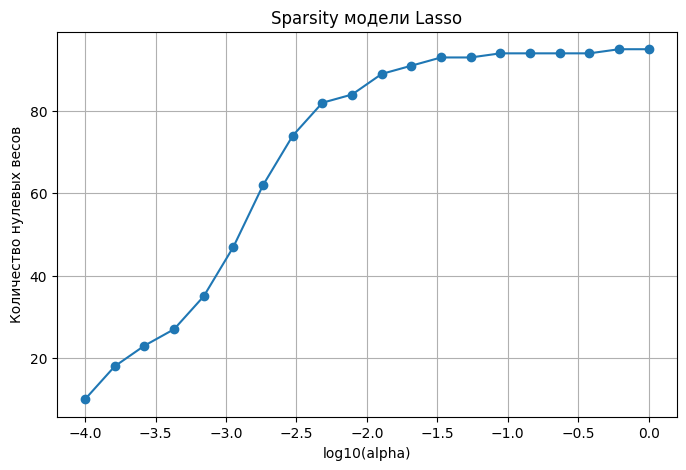

In [114]:
plt.figure(figsize=(8, 5))
plt.plot(np.log10(alphas), coefs, marker='o')
plt.xlabel('log10(alpha)')
plt.ylabel('Количество нулевых весов')
plt.title('Sparsity модели Lasso')
plt.grid(True)
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">
Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Линейная регрессия линейна по параметрам, так что если у нас есть признак `x1` и `x2`, то получить признак `x1 * x2` она не сможет самостоятельно, т.к. это не является линейной комбинацией

In [115]:
pair_series = train_df['pickup_cell'].astype(str) + train_df['dropoff_cell'].astype(str)
top_pairs = pair_series.value_counts().head(100).index

In [116]:
pair_to_id = {pair: idx for idx, pair in enumerate(top_pairs)}
train_df['pickup_dropoff_pair'] = pair_series.map(pair_to_id).fillna(-1).astype(int)

Добавим в качестве признака манхэттенское расстояние :)  
Лучшая задача, для рассчета этого признака

In [119]:
lat_scale = 111000  # метры
lon_scale = 85000   # метры

train_df['pickup_x'] = train_df['pickup_longitude'] * lon_scale
train_df['pickup_y'] = train_df['pickup_latitude'] * lat_scale
train_df['dropoff_x'] = train_df['dropoff_longitude'] * lon_scale
train_df['dropoff_y'] = train_df['dropoff_latitude'] * lat_scale

angle = np.radians(29) # поворот Манхэттена в радианах
cos_angle = np.cos(angle)
sin_angle = np.sin(angle)

train_df['pickup_rot_x'] = train_df['pickup_x'] * cos_angle - train_df['pickup_y'] * sin_angle
train_df['pickup_rot_y'] = train_df['pickup_x'] * sin_angle + train_df['pickup_y'] * cos_angle
train_df['dropoff_rot_x'] = train_df['dropoff_x'] * cos_angle - train_df['dropoff_y'] * sin_angle
train_df['dropoff_rot_y'] = train_df['dropoff_x'] * sin_angle + train_df['dropoff_y'] * cos_angle

train_df['manhattan_dist'] = (
    np.abs(train_df['pickup_rot_x'] - train_df['dropoff_rot_x']) +
    np.abs(train_df['pickup_rot_y'] - train_df['dropoff_rot_y'])
)

train_df['log_manhattan_dist'] = np.log1p(train_df['manhattan_dist'])

In [121]:
print(train_df['log_trip_duration'].corr(train_df['log_manhattan_dist']))
print(train_df['log_trip_duration'].corr(train_df['log_haversine']))

0.7295385495977786
0.7498822373942491


In [124]:
df = train_df[['hour', 'day_name', 'month', 'day_n',
       'anomaly1', 'anomaly2', 'log_haversine', 'is_peak_hour', 'is_free_road',
       'start_near_jfk_airport', 'start_near_laguardia_airport',
       'end_near_jfk_airport', 'end_near_laguardia_airport', 'pickup_cell',
       'dropoff_cell', 'passenger_count_flag', 'store_and_fwd_flag', 'pickup_dropoff_pair', 'log_manhattan_dist']]

y = train_df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=123)

numeric_features = ['day_n', 'log_haversine', 'log_manhattan_dist']
categorical_features = ['hour', 'day_name', 'month', 'anomaly1', 'anomaly2', 'is_peak_hour', 'is_free_road',
       'start_near_jfk_airport', 'start_near_laguardia_airport',
       'end_near_jfk_airport', 'end_near_laguardia_airport', 'pickup_cell',
       'dropoff_cell', 'passenger_count_flag', 'store_and_fwd_flag', 'pickup_dropoff_pair']

preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
        ]
)

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0)) 
    ])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [125]:
rmsle(y_pred, y_test)

0.45868068303499815

## Сгенерируем признак с помощью KNN

Обучим kNN для генерации признака "Среднее время поездки по соседям".  
Это соответствует интуиции из жизни: если бы вас попросили оценить время, которое вам потребуется, чтобы добраться из точки `A` в точку `B`, то разумно было бы каким-то образом усреднить время похожих (по точке старта и окончания, по времени, по дню недели и т.д.) поездок

In [139]:
from sklearn.neighbors import NearestNeighbors


class KNNTimeFeature(BaseEstimator, TransformerMixin):
    def __init__(self, features, k=10, return_log=True):
        self.features = features
        self.k = k
        self.return_log = return_log
        self.scaler = StandardScaler()

    def fit(self, X, y):
        self.X_train_ = X[self.features].copy()
        self.y_train_ = y.reset_index(drop=True)

        self.X_train_scaled_ = self.scaler.fit_transform(self.X_train_)
        self.nn_model_ = NearestNeighbors(n_neighbors=self.k, n_jobs=-1)
        self.nn_model_.fit(self.X_train_scaled_)

        return self

    def transform(self, X):
        X_target = X[self.features].copy()
        X_target_scaled = self.scaler.transform(X_target)
    
        distances, indices = self.nn_model_.kneighbors(X_target_scaled)
        knn_time_feature = np.array([
            self.y_train_.iloc[neighbor_indices].mean()
            for neighbor_indices in indices
        ])
    
        to_drop = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
        
        X_out = X.drop(columns=to_drop).copy()
    
        if self.return_log:
            X_out['log_knn_time'] = np.log1p(knn_time_feature)
        else:
            X_out['knn_time'] = knn_time_feature
    
        return X_out

In [140]:
features = [
    'hour', 'day_name', 'month', 'day_n',
    'anomaly1', 'anomaly2', 'log_haversine', 'is_peak_hour', 'is_free_road',
    'start_near_jfk_airport', 'start_near_laguardia_airport',
    'end_near_jfk_airport', 'end_near_laguardia_airport',
    'pickup_cell', 'dropoff_cell', 'passenger_count_flag',
    'store_and_fwd_flag', 'pickup_dropoff_pair', 'log_manhattan_dist',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'
]

df = train_df[features].copy()
y = train_df['log_trip_duration']


X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=123)

numeric_features = ['day_n', 'log_haversine', 'log_manhattan_dist', 'log_knn_time']
categorical_features = [
    'hour', 'day_name', 'month', 'anomaly1', 'anomaly2', 'is_peak_hour', 'is_free_road',
    'start_near_jfk_airport', 'start_near_laguardia_airport',
    'end_near_jfk_airport', 'end_near_laguardia_airport',
    'pickup_cell', 'dropoff_cell', 'passenger_count_flag',
    'store_and_fwd_flag', 'pickup_dropoff_pair'
]


full_pipeline = Pipeline([
    ('knn_feature', KNNTimeFeature(
        features=[
            'pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'hour', 'is_peak_hour', 'is_free_road'
        ],
        k=10,
        return_log=True
    )),
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
        ]
    )),
    ('regressor', Ridge(alpha=1.0))
])

full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)

In [141]:
rmsle(y_pred, y_test)

0.4275058927214554

Как и ожидалось, мы улучшили метрику!

### Просто запустим catboost...

In [146]:
from catboost import CatBoostRegressor

Напишем свой скейлер, который вернет датафрейм (а не np.ndarray), чтобы передать названия колонок в cat_features катбуста
Категориальные фичи обернем в строки, чтобы там не было float (даже если это были 0.0, 1.0 в качестве меток)

In [149]:
class DataFrameStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = self.scaler.transform(X_copy[self.columns])
        return X_copy

class CastCategoricals(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].astype(str)
        return X_copy

In [150]:
catboost_pipeline = Pipeline([
    ('knn_feature', KNNTimeFeature(
        features=[
            'pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'hour', 'is_peak_hour', 'is_free_road'
        ],
        k=10,
        return_log=True
    )),
    ('cast_cat', CastCategoricals(columns=categorical_features)),
    ('scale_numeric', DataFrameStandardScaler(columns=numeric_features)),
    ('regressor', CatBoostRegressor(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        verbose=100,
        cat_features=categorical_features
    ))
])


catboost_pipeline.fit(X_train, y_train)
y_pred = catboost_pipeline.predict(X_test)

0:	learn: 0.7411909	total: 541ms	remaining: 4m 29s
100:	learn: 0.3792565	total: 48.2s	remaining: 3m 10s
200:	learn: 0.3757925	total: 1m 32s	remaining: 2m 17s
300:	learn: 0.3740282	total: 2m 16s	remaining: 1m 29s
400:	learn: 0.3725759	total: 2m 59s	remaining: 44.2s
499:	learn: 0.3716041	total: 3m 39s	remaining: 0us


In [151]:
rmsle(y_pred, y_test)

0.4154049406879517

Мы ограничены в использовании (по условию) только моделями линейной регрессии, однако, бустинг без тюнинга не дал бы нам существенного прироста метрики.